In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pathlib import Path

In [13]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../../data')

with open(path / 'low_g_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [14]:
# define independent variables and dependent variable
maneuver = 'LOW-G'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [15]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# LOW-G
# 0    257183
# 1      1722
# Name: count, dtype: int64

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [16]:

params = {
    'rf__n_estimators': [50],  # 100, 200
    'rf__max_depth': [None],  # 5, 10
    'rf__min_samples_split': [2],  # 5, 10
    'rf__min_samples_leaf': [1],  # 2, 4
    'rf__max_features': ['log2'],  # 'sqrt'
    'rf__bootstrap': [True],  # False
    'rf__class_weight': ['balanced'],
    'rf__random_state': [42],
    'rf__n_jobs': [-1]
}

# create a pipeline
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# grid search with cross-validation
f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

## Make Predictions for Model Evaluation

In [17]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test.values, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     51437
           1     1.0000    0.9971    0.9985       344

    accuracy                         1.0000     51781
   macro avg     1.0000    0.9985    0.9993     51781
weighted avg     1.0000    1.0000    1.0000     51781



In [22]:
print(confusion_matrix(y_test, y_pred))

[[51437     0]
 [    1   343]]


In [18]:
recall_scorer = make_scorer(recall_score, average='weighted')
# Create learning curve data using learning_curve function with recall scoring
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring=recall_scorer, train_sizes=np.linspace(0.1, 1.0, 10)
)

In [19]:
# Calculate mean and standard deviation for training and cross-validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### Learning Curve Analysis

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It's a tool to diagnose bias and variance.

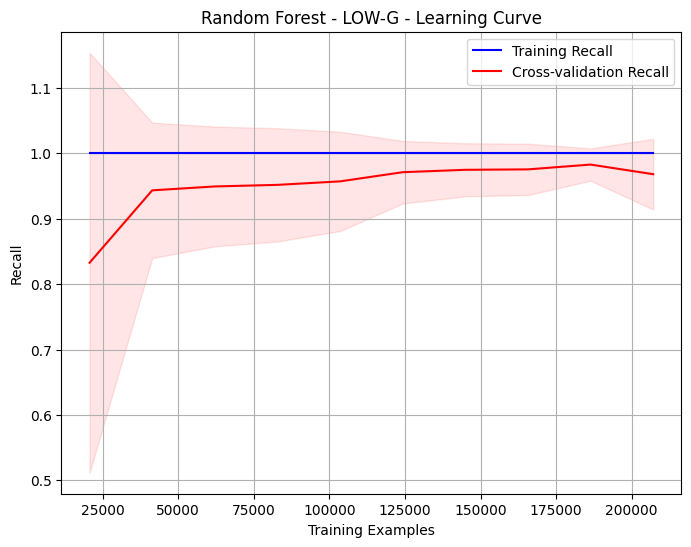

In [20]:
# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation Recall', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='red')

plt.title(f'Random Forest - {maneuver} - Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.grid()
plt.show()

### Feature Importance

Understanding which features have the most impact on predictions can provide insights into the data and the model's behavior. Here, we rank the features based on their importance.

Most important variables:
Altitude(MSL): 0.28447842882329966
Yaw: 0.045921583240967866
Yaw Acceleration: 0.07864012393187736
Gross Weight: 0.0039711342713507885
Altitude(AGL): 0.1467434258765614
Pitch Acceleration: 0.07968419860708995
Vert. Speed: 0.007324957896244195
Cyclic Pitch Pos-[0]: 0.0020151047593346878
Roll Acceleration: 0.08385280109191866
Airspeed(True): 0.13668113110557897
Rotor Torque-[0]: 0.0
Collective Pos-[0]: 0.0017344549753597071
Rotor RPM-[0]: 0.017247984244272055
Cyclic Roll Pos-[0]: 0.0019747532238404424
Sideslip Angle: 0.010176746962487609
Roll: 0.0502623696731662
Pitch: 0.04893398302304429
Pedal Pos: 0.0003568182936061047
Wind Speed(True): 0.0


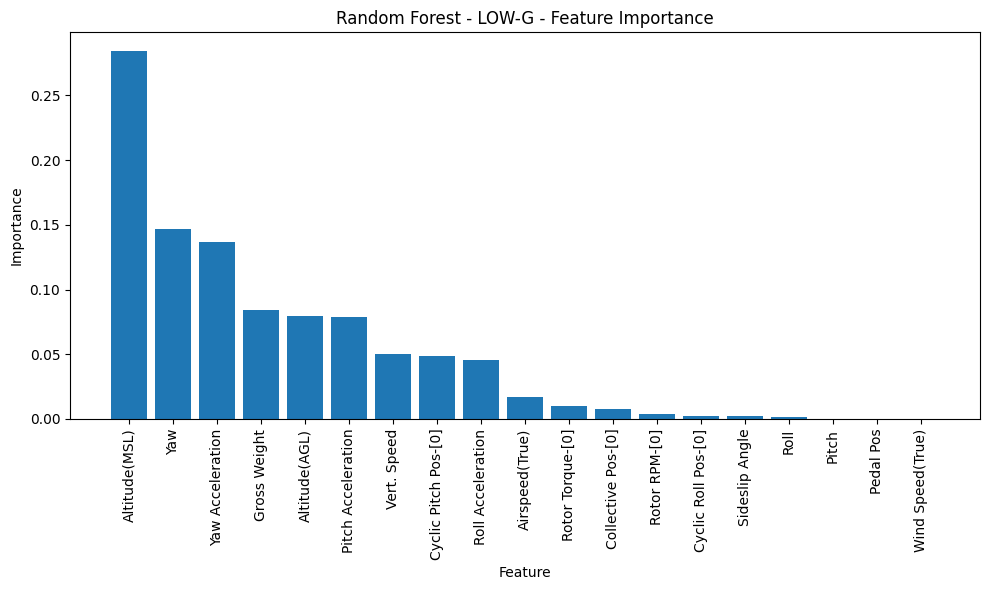

In [21]:

rf_model = best_model.named_steps['rf']
feature_importances = rf_model.feature_importances_

# Train the model on the entire dataset
best_model.fit(X, y)

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

# Retrieve feature names
feature_names = list(X_train.columns)

# Print the most important variables
print("Most important variables:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {sorted_feature_importances[i]}")
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Random Forest - {maneuver} - Feature Importance')
plt.tight_layout()
plt.show()

## Model Evaluation Summary:

### Learning Curve Analysis:
The random forest model learning curve shows the recall score for the cross validation training steadily increased with a higher number of training examples. This suggests that the random forest model may not be overfit on the Low Gravity dataset.

### Feature Importance Analysis:
- Altitude(MSL), Yaw, and Yaw Acceleration were the top features.
- These features account for a verify high proportion of importance, over .5.
- Future research could look into how these variables interact and how their changes could correlate with one another.